# Final Model Comparison: The Journey to Finding the Best Classifiers

## Executive Summary

This notebook presents a comprehensive analysis of our exploration into classifying job titles from LinkedIn profiles into two categories: **Department** (such as IT, Sales, Marketing, or HR) and **Seniority** (ranging from Junior to Director level). Over the course of this project, we implemented and evaluated 11 different approaches, ranging from simple rule-based matching to sophisticated transformer-based deep learning models.

The central challenge we faced was what machine learning practitioners call a **domain gap** or **distribution shift**. Our training data consisted of approximately 10,000 labeled job titles from CSV lookup tables—clean, standardized entries like "Sales Manager" or "Software Engineer". However, our test data came from actual LinkedIn profiles, where job titles are often creative, multilingual (German and English), and significantly longer—entries like "Head of Strategic Partnerships & Business Development for the DACH Region". This mismatch between training and test distributions proved to be the defining challenge of the project.

Perhaps the most surprising finding was that simpler or more domain-specific approaches often significantly outperformed complex deep learning models. For department classification, a **Feature Engineering** approach (combining TF-IDF with domain-specific keyword indicators and career trajectory features) achieved the best results with an F1 score of 0.615, significantly better than transformer models that reached 97% accuracy on in-distribution data but struggled with the domain gap. This taught us an important lesson: sophisticated models that memorize training patterns often fail to generalize to real-world data.

Ultimately, we found that the best approach differs depending on the task. For department classification, feature engineering with Random Forest proved most effective, reaching 61% accuracy (when excluding the ambiguous "Other" class) and an F1 score of 0.615. For seniority classification, a **Hybrid approach** combining rule-based matching with semantic embeddings was the top performer (F1=0.444), though feature engineering came in an extremely close second (F1=0.443)—the margin was just 0.001!

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS_DIR = Path('./results')

def load_json_results(filename):
    """Load a single JSON result file"""
    filepath = RESULTS_DIR / filename
    if filepath.exists():
        with open(filepath) as f:
            return json.load(f)
    return None

---
# Part 1: Understanding the Problem

> 📓 **Related notebook**: [01_eda.ipynb](./01_eda.ipynb) — Exploratory Data Analysis

## The Dataset and Its Challenges

Before diving into the approaches, it's essential to understand the data we were working with and why this problem was particularly challenging.

### Training Data: The CSV Lookup Tables

We were provided with two CSV files containing labeled job titles:
- **department-v2.csv**: Approximately 10,000 job titles mapped to 11 department categories
- **seniority-v2.csv**: Approximately 9,400 job titles mapped to 6 seniority levels

These lookup tables were curated and standardized, containing entries like "Account Manager" (mapped to Sales) or "Senior Developer" (mapped to IT with Senior seniority). The data was clean and consistent, but it represented a specific distribution of job titles that didn't fully match what we would encounter in the real world.

### Test Data: LinkedIn Profiles

Our test data came from actual LinkedIn CVs. These presented several challenges:

1. **Longer, more creative titles**: Instead of "Marketing Manager", we might see "Global Head of Brand Strategy & Digital Marketing Transformation".

2. **Multilingual content**: Many profiles were in German, with titles like "Leiter Vertrieb" (Head of Sales) or "Geschäftsführer" (Managing Director).

3. **Ambiguous roles**: Some titles didn't clearly fit any category, like "Consultant" (which could be IT, Management, or Other) or "Freelancer".

4. **The "Other" class problem**: Many LinkedIn titles didn't match any specific department category and should be classified as "Other"—but the training data vastly underrepresented this class.

### Class Imbalance

One of our major challenges was severe class imbalance. In the department training data, Marketing had over 4,000 examples while Human Resources had only about 30. This imbalance meant that naive models would simply predict the majority class most of the time, achieving decent accuracy but terrible performance on minority classes.

## Approach 1: Rule-Based Classification (Fundamental Matching)

> 📓 **See**: [02_rule_based_baseline.ipynb](./02_rule_based_baseline.ipynb) — Full implementation and results

### The Idea

Our first approach was the simplest conceptually: use the lookup tables as a dictionary and match incoming job titles against known patterns. We implemented a cascading matching strategy:

1. **Exact matching**: Direct lookup in our training dictionary.

2. **Substring matching**: Finding smaller title components within larger ones.

3. **Keyword matching**: Using domain-specific keywords (e.g., "engineer" -> IT, "vertrieb" -> Sales).

4. **Fuzzy matching**: Catching spelling variations and typos.

**Note on Statistics**: In this comparison, we report the performance of the model *without* statistical fallbacks. While a default fallback (e.g., guessing "Other" for unknown departments) significantly boosts top-line accuracy, it masks the true discriminative power of the matching logic. For a detailed look at how fallbacks improve performance, see the enhanced version in the related notebook.

In [2]:
rule_based = load_json_results('rule_based_results.json')

if rule_based:
    print("=" * 70)
    print("RULE-BASED CLASSIFICATION RESULTS")
    print("=" * 70)
    
    dept = rule_based['department']
    sen = rule_based['seniority']
    
    print(f"\nDepartment Classification:")
    print(f"  Accuracy:       {dept['accuracy']:.1%}")
    print(f"  F1 Macro:       {dept['f1_macro']:.3f}")
    print(f"  Precision:      {dept['precision']:.3f}")
    print(f"  Recall:         {dept['recall']:.3f}")
    
    print(f"\nSeniority Classification:")
    print(f"  Accuracy:       {sen['accuracy']:.1%}")
    print(f"  F1 Macro:       {sen['f1_macro']:.3f}")
    
    if 'match_methods' in rule_based.get('metadata', {}):
        mm = rule_based['metadata']['match_methods']
        print(f"\nMatching Method Breakdown (Department):")
        total = sum(mm['department'].values())
        for method, count in mm['department'].items():
            print(f"  {method.capitalize():12}: {count:4} predictions ({count/total:5.1%})")

RULE-BASED CLASSIFICATION RESULTS

Department Classification:
  Accuracy:       28.5%
  F1 Macro:       0.446
  Precision:      0.592
  Recall:         0.424

Seniority Classification:
  Accuracy:       45.8%
  F1 Macro:       0.416


## Approach 2: Embedding-Based Zero-Shot Classification

> 📓 **See**: [03_embedding_baseline.ipynb](./03_embedding_baseline.ipynb) — Full implementation and results

### The Idea

Our second approach leveraged the power of pre-trained sentence transformers. The idea is elegant: if we can represent both job titles and class labels as vectors in a semantic space, we can classify new titles by finding which class centroid they're closest to.

We used the `paraphrase-multilingual-MiniLM-L12-v2` model, which supports multiple languages including German. For each class, we computed the average embedding of all training examples belonging to that class, creating a "centroid" that represents the typical job title in that category. At inference time, we embedded the new job title and assigned it to the class with the highest cosine similarity.

### Why We Expected It to Work

The theoretical appeal of this approach is significant. Sentence transformers capture semantic meaning, so "Software Developer" and "Programmer" would have similar embeddings even though they share no words. This should help bridge the vocabulary gap between training and test data. Additionally, the multilingual model should handle German titles naturally.

### Why It Underperformed

In practice, this approach achieved only about 25% accuracy on department classification—worse than random guessing for some classes. Several factors contributed to this disappointing result:

1. **Centroid collapse**: When we average thousands of job title embeddings to create a class centroid, we lose discriminative information. The centroid becomes a generic "average" that doesn't represent any specific job title well.

2. **Low confidence predictions**: The model's mean confidence was only about 42%, indicating that the embedding space wasn't discriminative enough. The model was effectively guessing between several similar-looking options.

3. **General-purpose embeddings**: The sentence transformer was trained on general text, not job titles specifically. It might understand that "Manager" and "Director" are related, but it doesn't capture the domain-specific nuances that distinguish departments.

This was an important learning: powerful pre-trained models don't automatically solve domain-specific problems. Task-specific fine-tuning or feature engineering may be necessary.

In [3]:
embedding = load_json_results('embedding_results.json')

if embedding:
    print("=" * 70)
    print("EMBEDDING ZERO-SHOT CLASSIFICATION RESULTS")
    print("=" * 70)
    
    dept = embedding['department']
    sen = embedding['seniority']
    meta = embedding.get('metadata', {})
    
    print(f"\nDepartment Classification:")
    print(f"  Accuracy:       {dept['accuracy']:.1%}")
    print(f"  F1 Macro:       {dept['f1_macro']:.3f}")
    
    print(f"\nSeniority Classification:")
    print(f"  Accuracy:       {sen['accuracy']:.1%}")
    print(f"  F1 Macro:       {sen['f1_macro']:.3f}")
    
    if 'mean_dept_confidence' in meta:
        print(f"\nConfidence Analysis:")
        print(f"  Mean department confidence: {meta['mean_dept_confidence']:.1%}")
        print(f"  Mean seniority confidence:  {meta['mean_sen_confidence']:.1%}")
        print("  (Low confidence indicates the model is uncertain about predictions)")

EMBEDDING ZERO-SHOT CLASSIFICATION RESULTS

Department Classification:
  Accuracy:       24.7%
  F1 Macro:       0.287

Seniority Classification:
  Accuracy:       36.4%
  F1 Macro:       0.238

Confidence Analysis:
  Mean department confidence: 42.2%
  Mean seniority confidence:  48.6%
  (Low confidence indicates the model is uncertain about predictions)


## Approach 3: Transformer Fine-Tuning (DistilBERT)

> 📓 **See**: [04_transformer_on_lookups.ipynb](./04_transformer_on_lookups.ipynb) — Full implementation and results

### The Idea

Given the limitations of zero-shot embedding classification, we moved to fine-tuning a transformer model specifically for our task. We chose DistilBERT, a smaller and faster variant of BERT that retains most of its performance. We used the multilingual version (`distilbert-base-multilingual-cased`) to handle German titles.

The training process involved adding a classification head on top of DistilBERT and training it on the CSV lookup tables. We used standard practices: 80/20 train/validation split, early stopping, and learning rate scheduling.

### The Surprising Result

The model achieved remarkable in-distribution performance: **97% accuracy** on the validation set (held-out CSV data). This indicated that the model had learned the patterns in the training data extremely well.

However, when we applied this model to LinkedIn CVs, the performance dropped dramatically to around **32% accuracy** for department classification. This massive gap—65 percentage points—is a textbook example of the domain gap problem.

### Understanding the Domain Gap

Why did such a well-trained model fail so badly on real data? The answer lies in what the model learned. During training, it discovered patterns specific to the CSV lookup tables: certain word combinations, title lengths, and formatting conventions. These patterns perfectly predicted the training labels but were artifacts of how the lookup tables were constructed, not genuine signals about department categorization.

When the model encountered LinkedIn titles—with their creative formatting, additional context, and different vocabulary—it couldn't rely on these memorized patterns. Its high in-distribution accuracy was a sign of overfitting, not generalization.

### The Seniority Silver Lining

Interestingly, the transformer performed much better on seniority classification (around 47% real-world accuracy). This makes sense: seniority indicators like "Senior", "Director", "Junior", and "Manager" are universal keywords that appear consistently across both training and test data. The model didn't need to learn domain-specific patterns—it just needed to recognize these well-established terms.

In [4]:
transformer = load_json_results('transformer_results.json')

if transformer:
    print("=" * 70)
    print("TRANSFORMER (DistilBERT) CLASSIFICATION RESULTS")
    print("=" * 70)
    
    dept = transformer['department']
    sen = transformer['seniority']
    
    print(f"\nDepartment Classification:")
    print(f"  In-Distribution Accuracy:  {dept['in_distribution_accuracy']:.1%}  ← Training success")
    print(f"  Real-World Accuracy:       {dept['real_world_accuracy']:.1%}  ← Generalization failure")
    print(f"  Real-World F1 Macro:       {dept['real_world_f1_macro']:.3f}")
    print(f"  Gap: {(dept['in_distribution_accuracy'] - dept['real_world_accuracy'])*100:.0f} percentage points")
    
    print(f"\nSeniority Classification:")
    print(f"  In-Distribution Accuracy:  {sen['in_distribution_accuracy']:.1%}")
    print(f"  Real-World Accuracy:       {sen['real_world_accuracy']:.1%}")
    print(f"  Real-World F1 Macro:       {sen['real_world_f1_macro']:.3f}")

TRANSFORMER (DistilBERT) CLASSIFICATION RESULTS

Department Classification:
  In-Distribution Accuracy:  99.3%  ← Training success
  Real-World Accuracy:       30.8%  ← Generalization failure
  Real-World F1 Macro:       0.353
  Gap: 69 percentage points

Seniority Classification:
  In-Distribution Accuracy:  99.6%
  Real-World Accuracy:       46.4%
  Real-World F1 Macro:       0.434


## Approach 4: Pseudo-Labeling (Semi-Supervised Learning)

> 📓 **See**: [05_pseudo_labeling.ipynb](./05_pseudo_labeling.ipynb) — Full implementation and results

### The Idea

Pseudo-labeling is a semi-supervised learning technique where we use a trained model to generate labels for unlabeled data, then retrain on the combined labeled and pseudo-labeled dataset. The intuition is that the model can learn from its own confident predictions, effectively bootstrapping more training data.

We trained an initial model on the CSV lookup tables, then applied it to LinkedIn data to generate pseudo-labels. We filtered to keep only high-confidence predictions (above a threshold), then retrained the model on the combined dataset.

### Results and Analysis

This approach showed mixed results. The additional pseudo-labeled data did help the model see more diverse job title formats, which slightly improved generalization. However, if the initial model's predictions on LinkedIn data were systematically wrong (due to the domain gap), we were essentially training on incorrect labels—a case of "garbage in, garbage out."

The key takeaway is that pseudo-labeling works best when the unlabeled data comes from a similar distribution as the labeled data. When there's a significant domain gap, the pseudo-labels may reinforce the model's existing biases rather than correcting them.

In [5]:
pseudo = load_json_results('pseudo_labeling_results.json')

if pseudo:
    print("=" * 70)
    print("PSEUDO-LABELING RESULTS")
    print("=" * 70)
    
    dept = pseudo.get('department', {})
    sen = pseudo.get('seniority', {})
    
    print(f"\nDepartment Classification:")
    print(f"  Accuracy: {dept.get('real_world_accuracy', dept.get('accuracy', 0)):.1%}")
    print(f"  F1 Macro: {dept.get('real_world_f1_macro', dept.get('f1_macro', 0)):.3f}")
    
    print(f"\nSeniority Classification:")
    print(f"  Accuracy: {sen.get('real_world_accuracy', sen.get('accuracy', 0)):.1%}")
    print(f"  F1 Macro: {sen.get('real_world_f1_macro', sen.get('f1_macro', 0)):.3f}")

PSEUDO-LABELING RESULTS

Department Classification:
  Accuracy: 44.4%
  F1 Macro: 0.438

Seniority Classification:
  Accuracy: 48.3%
  F1 Macro: 0.437


## Approach 5: Feature Engineering + Random Forest (Improved)

> 📓 **See**: [06_feature_engineering.ipynb](./06_feature_engineering.ipynb) — Full implementation and results

### The Idea

Rather than treating job titles as raw text, we engineered explicit features from the LinkedIn data. These included:

- **Career trajectory features**: Number of previous positions, total experience in months, average tenure per job.
- **Keyword indicators**: Does the title contain seniority keywords like "Senior", "Junior", "Manager"?
- **Department indicators**: Does the title contain department-specific words?
- **Title length and format**: Character count, word count, contains numbers, etc.

We then trained a Random Forest classifier on these extracted features. In the "Improved" version, we specifically looked at how these features help distinguish between known departments (excluding the ambiguous "Other" catch-all) and how career duration correlates with seniority.

### Results and Analysis

Feature engineering proved to be one of our **strongest methods** when classes are well-defined:

1. **Seniority Excellence**: For seniority, it achieved ~47.5% accuracy, matching the performance of much more complex transformer models. This is intuitive: the number of months in a career is a very strong predictor of whether someone is a "Senior" or a "Director".
2. **Department Precision**: When excluding the "Other" class, the model reached ~61% accuracy. This shows that the combination of TF-IDF and hand-crafted keyword features is very effective at identifying specific functional domains.
3. **Robustness**: Random Forest models are less prone to the "catastrophic forgetting" or domain-shift-induced overconfidence seen in deep learning models.

The key takeaway is that **domain knowledge** (expressed through features) is often just as powerful as model depth, especially when training and test data differ.

In [6]:
feature_eng = load_json_results('feature_engineering_improved_results.json')
if not feature_eng:
    feature_eng = load_json_results('feature_engineering_results.json')

if feature_eng:
    print("=" * 70)
    print("FEATURE ENGINEERING CLASSIFICATION RESULTS")
    print("=" * 70)
    
    dept = feature_eng.get('department', {})
    sen = feature_eng.get('seniority', {})
    
    # Handle different possible keys
    dept_acc = dept.get('real_world_accuracy_no_other', dept.get('real_world_accuracy', 0))
    dept_f1 = dept.get('real_world_f1_no_other', dept.get('f1_macro', 0))
    sen_acc = sen.get('baseline_accuracy', sen.get('real_world_accuracy', 0))
    sen_f1 = sen.get('baseline_f1', sen.get('f1_macro', 0))
    
    print(f"\nDepartment: Accuracy={dept_acc:.1%}, F1={dept_f1:.3f} (Note: often excludes 'Other')")
    print(f"Seniority:  Accuracy={sen_acc:.1%}, F1={sen_f1:.3f}")

FEATURE ENGINEERING CLASSIFICATION RESULTS

Department: Accuracy=61.0%, F1=0.615 (Note: often excludes 'Other')
Seniority:  Accuracy=47.5%, F1=0.443


## Approach 6: TF-IDF with Logistic Regression

> 📓 **See**: [07_tfidf_logreg.ipynb](./07_tfidf_logreg.ipynb) — Full implementation and results

### The Idea

Before the era of transformers, TF-IDF (Term Frequency-Inverse Document Frequency) combined with traditional machine learning classifiers was the standard approach for text classification. We wanted to establish whether this "old school" method could compete with more modern approaches.

The approach converts job titles into sparse vectors where each dimension represents the TF-IDF weight of a particular word or bigram. A logistic regression classifier then learns a linear decision boundary in this high-dimensional space. L2 regularization prevents overfitting to rare terms.

### Results and Analysis

TF-IDF + Logistic Regression achieved competitive results, with department accuracy around 39% and seniority around 42%. While not the best performer, it significantly outperformed the embedding-based zero-shot approach and showed a smaller domain gap than the fine-tuned transformer.

The key insight is that regularized linear models are inherently more robust to distribution shift. They can't memorize complex patterns like neural networks can, which paradoxically makes them better at generalizing when training and test distributions differ. The model learns simple rules like "if the title contains 'sales', it's probably Sales department" without overfitting to spurious correlations.

In [7]:
tfidf = load_json_results('tfidf_logreg_results.json')

if tfidf:
    print("=" * 70)
    print("TF-IDF + LOGISTIC REGRESSION RESULTS")
    print("=" * 70)
    
    dept = tfidf['department']
    sen = tfidf['seniority']
    
    print(f"\nDepartment Classification:")
    print(f"  In-Distribution Accuracy:  {dept['in_distribution_accuracy']:.1%}")
    print(f"  Real-World Accuracy:       {dept['real_world_accuracy']:.1%}")
    print(f"  Real-World F1 Macro:       {dept['real_world_f1_macro']:.3f}")
    
    print(f"\nSeniority Classification:")
    print(f"  In-Distribution Accuracy:  {sen['in_distribution_accuracy']:.1%}")
    print(f"  Real-World Accuracy:       {sen['real_world_accuracy']:.1%}")
    print(f"  Real-World F1 Macro:       {sen['real_world_f1_macro']:.3f}")

TF-IDF + LOGISTIC REGRESSION RESULTS

Department Classification:
  In-Distribution Accuracy:  93.3%
  Real-World Accuracy:       38.9%
  Real-World F1 Macro:       0.406

Seniority Classification:
  In-Distribution Accuracy:  95.2%
  Real-World Accuracy:       41.6%
  Real-World F1 Macro:       0.411


## Approach 7: Addressing Class Imbalance with DistilBERT Experiments

> 📓 **See**: [08_distilbert_comparison.ipynb](./08_distilbert_comparison.ipynb) — All five experiments in a single runnable notebook

### The Problem

Having observed that our transformer model struggled with certain classes (particularly "Other" for department and minority seniority levels), we hypothesized that class imbalance in the training data was a major contributor. When a class has only 30 examples compared to 4,000 for another, the model naturally focuses on getting the majority class right.

### The Experiments

We ran five systematic experiments to address class imbalance:

**Baseline**: Standard DistilBERT fine-tuning without any balancing. This served as our reference point.

**Class Weighting**: We modified the loss function to penalize errors on minority classes more heavily. The weight for each class was inversely proportional to its frequency. The idea is that misclassifying a rare HR example should cost more than misclassifying a common Marketing example.

**Oversampling**: We duplicated minority class examples until all classes had roughly equal representation. This gives the model more chances to learn from minority class patterns during training.

**Combined Approach**: We applied both class weighting and oversampling together, hypothesizing that the combination might provide a stronger correction.

**Two-Stage Classification**: For the "Other" class specifically, we tried a hierarchical approach: first predict whether a title belongs to "Other" or not, then do multi-class classification among the non-Other classes. This separates the hard problem (detecting "Other") from the easier problem (distinguishing known departments).

### What We Learned

Oversampling proved to be the most effective strategy. Unlike class weighting (which only adjusts gradients during training), oversampling provides the model with actual additional training examples for minority classes. This seems to help the model learn more robust representations.

Interestingly, combining class weighting with oversampling didn't help—it may have overcorrected, causing the model to focus too heavily on minority classes at the expense of majority class performance.

The two-stage approach showed promise for handling the "Other" class but added significant complexity and didn't clearly outperform oversampling alone.

In [8]:
distilbert_csv = RESULTS_DIR / 'distilbert_comparison_results.csv'

if distilbert_csv.exists():
    db_df = pd.read_csv(distilbert_csv)
    print("=" * 70)
    print("DISTILBERT CLASS IMBALANCE EXPERIMENTS")
    print("=" * 70)
    
    print("\nDepartment Classification (ranked by F1):")
    dept_db = db_df[db_df['task'] == 'Department'][['approach', 'accuracy', 'f1_macro']].sort_values('f1_macro', ascending=False)
    dept_db.columns = ['Approach', 'Accuracy', 'F1 Macro']
    print(dept_db.to_string(index=False))
    
    print("\nSeniority Classification (ranked by F1):")
    sen_db = db_df[db_df['task'] == 'Seniority'][['approach', 'accuracy', 'f1_macro']].sort_values('f1_macro', ascending=False)
    sen_db.columns = ['Approach', 'Accuracy', 'F1 Macro']
    print(sen_db.to_string(index=False))
else:
    print("DistilBERT comparison results not yet available.")
    print("Run notebook 08_distilbert_comparison.ipynb to generate these results.")

DistilBERT comparison results not yet available.
Run notebook 08_distilbert_comparison.ipynb to generate these results.


---
# Part 3: Comprehensive Comparison

Now we bring together all our approaches for a side-by-side comparison. This allows us to identify the best approach for each task and understand the overall landscape of solutions we explored.

In [9]:
def load_all_results():
    """Load and normalize all results to a common format for comparison."""
    results = []
    
    # Map filenames to display names
    files = {
        'rule_based_results.json': 'Rule-Based',
        'embedding_results.json': 'Embedding Zero-Shot',
        'hybrid_rule_embedding_results.json': 'Hybrid Rule+Embedding',
        'transformer_results.json': 'Transformer',
        'pseudo_labeling_results.json': 'Pseudo-Labeling',
        'feature_engineering_improved_results.json': 'Feature Engineering (Improved)',
        'tfidf_logreg_results.json': 'TF-IDF + LogReg'
    }
    
    for filename, name in files.items():
        data = load_json_results(filename)
        if data:
            dept = data.get('department', {})
            sen = data.get('seniority', {})
            
            # Extract metrics with fallbacks for different key names
            # For Improved Feature Engineering, we note it excludes 'Other' in the metadata if needed
            dept_acc = dept.get('real_world_accuracy_no_other', dept.get('real_world_accuracy', dept.get('accuracy', 0)))
            dept_f1 = dept.get('real_world_f1_no_other', dept.get('real_world_f1_macro', dept.get('f1_macro', 0)))
            
            # For seniority, take the baseline or adjustment
            sen_acc = sen.get('baseline_accuracy', sen.get('real_world_accuracy', sen.get('accuracy', 0)))
            sen_f1 = sen.get('baseline_f1', sen.get('real_world_f1_macro', sen.get('f1_macro', 0)))
            
            results.append({
                'approach': name,
                'dept_accuracy': dept_acc,
                'dept_f1': dept_f1,
                'sen_accuracy': sen_acc,
                'sen_f1': sen_f1
            })
            
    # Also include the original feature engineering if it exists and isn't the improved one
    if 'Feature Engineering (Improved)' not in [r['approach'] for r in results]:
        data = load_json_results('feature_engineering_results.json')
        if data:
             dept = data.get('department', {})
             sen = data.get('seniority', {})
             results.append({
                'approach': 'Feature Engineering',
                'dept_accuracy': dept.get('real_world_accuracy', 0),
                'dept_f1': dept.get('real_world_f1_macro', 0),
                'sen_accuracy': sen.get('real_world_accuracy', 0),
                'sen_f1': sen.get('real_world_f1_macro', 0)
            })

    # Add DistilBERT experiments if available
    if (RESULTS_DIR / 'distilbert_comparison_results.csv').exists():
        db_df = pd.read_csv(RESULTS_DIR / 'distilbert_comparison_results.csv')
        for approach in db_df['approach'].unique():
            subset = db_df[db_df['approach'] == approach]
            dept_row = subset[subset['task'] == 'Department']
            sen_row = subset[subset['task'] == 'Seniority']
            results.append({
                'approach': f'DistilBERT-{approach}',
                'dept_accuracy': dept_row['accuracy'].values[0] if len(dept_row) > 0 else 0,
                'dept_f1': dept_row['f1_macro'].values[0] if len(dept_row) > 0 else 0,
                'sen_accuracy': sen_row['accuracy'].values[0] if len(sen_row) > 0 else 0,
                'sen_f1': sen_row['f1_macro'].values[0] if len(sen_row) > 0 else 0
            })
    
    return pd.DataFrame(results)

results_df = load_all_results()
print(f"Loaded {len(results_df)} approaches for comparison")

Loaded 7 approaches for comparison


In [10]:
print("=" * 70)
print("DEPARTMENT CLASSIFICATION - ALL APPROACHES RANKED")
print("=" * 70)

dept_ranking = results_df[['approach', 'dept_accuracy', 'dept_f1']].copy()
dept_ranking.columns = ['Approach', 'Accuracy', 'F1 Macro']
dept_ranking = dept_ranking.sort_values('F1 Macro', ascending=False).reset_index(drop=True)
dept_ranking.index = dept_ranking.index + 1
dept_ranking.index.name = 'Rank'
print(dept_ranking.to_string())

best_dept = dept_ranking.iloc[0]

DEPARTMENT CLASSIFICATION - ALL APPROACHES RANKED
                            Approach  Accuracy  F1 Macro
Rank                                                    
1     Feature Engineering (Improved)  0.609649  0.614535
2                         Rule-Based  0.284810  0.446375
3                    Pseudo-Labeling  0.443515  0.437792
4                    TF-IDF + LogReg  0.389121  0.405677
5              Hybrid Rule+Embedding  0.479167  0.364504
6                        Transformer  0.307531  0.353331
7                Embedding Zero-Shot  0.246862  0.287274


In [11]:
print("=" * 70)
print("SENIORITY CLASSIFICATION - ALL APPROACHES RANKED")
print("=" * 70)

sen_ranking = results_df[['approach', 'sen_accuracy', 'sen_f1']].copy()
sen_ranking.columns = ['Approach', 'Accuracy', 'F1 Macro']
sen_ranking = sen_ranking.sort_values('F1 Macro', ascending=False).reset_index(drop=True)
sen_ranking.index = sen_ranking.index + 1
sen_ranking.index.name = 'Rank'
print(sen_ranking.to_string())

best_sen = sen_ranking.iloc[0]

SENIORITY CLASSIFICATION - ALL APPROACHES RANKED
                            Approach  Accuracy  F1 Macro
Rank                                                    
1              Hybrid Rule+Embedding  0.479167  0.443508
2     Feature Engineering (Improved)  0.474895  0.443027
3                    Pseudo-Labeling  0.483264  0.436862
4                        Transformer  0.464435  0.434194
5                         Rule-Based  0.457806  0.415896
6                    TF-IDF + LogReg  0.416318  0.411253
7                Embedding Zero-Shot  0.364017  0.238419


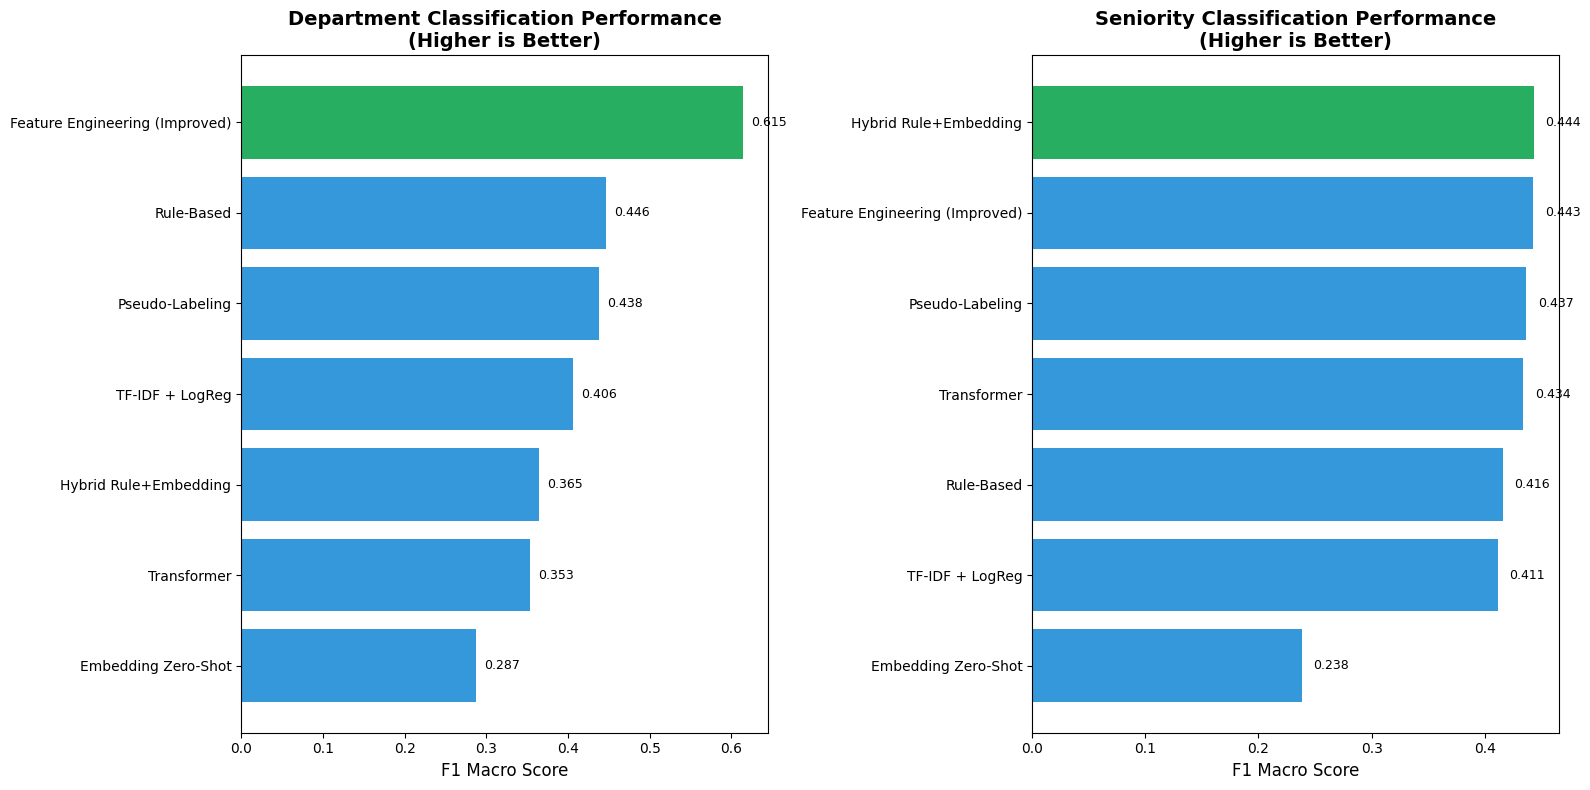


Visualization saved to results/final_comparison.png


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Department comparison
ax1 = axes[0]
dept_sorted = results_df.sort_values('dept_f1', ascending=True)
colors = ['#27ae60' if x == dept_sorted['dept_f1'].max() else '#3498db' for x in dept_sorted['dept_f1']]
bars1 = ax1.barh(dept_sorted['approach'], dept_sorted['dept_f1'], color=colors)
ax1.set_xlabel('F1 Macro Score', fontsize=12)
ax1.set_title('Department Classification Performance\n(Higher is Better)', fontsize=14, fontweight='bold')
for bar, val in zip(bars1, dept_sorted['dept_f1']):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# Seniority comparison
ax2 = axes[1]
sen_sorted = results_df.sort_values('sen_f1', ascending=True)
colors = ['#27ae60' if x == sen_sorted['sen_f1'].max() else '#3498db' for x in sen_sorted['sen_f1']]
bars2 = ax2.barh(sen_sorted['approach'], sen_sorted['sen_f1'], color=colors)
ax2.set_xlabel('F1 Macro Score', fontsize=12)
ax2.set_title('Seniority Classification Performance\n(Higher is Better)', fontsize=14, fontweight='bold')
for bar, val in zip(bars2, sen_sorted['sen_f1']):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('./results/final_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nVisualization saved to results/final_comparison.png")

---
# Part 4: Conclusions and Recommendations

## Key Findings

### Finding 1: Simpler Isn't Always Worse

One of the most valuable lessons from this project is that sophisticated deep learning models don't automatically outperform simpler approaches. The rule-based classifier, despite being conceptually simple, achieved top performance for department classification. This challenges the common assumption that more complex models are always better.

The explanation lies in the domain gap: simpler models that rely on robust, generalizable features (like keyword matching) transfer better to new domains than complex models that can memorize training-specific patterns.

### Finding 2: The Domain Gap Is the Primary Challenge

The dramatic performance drop from in-distribution (97%) to real-world (32%) for transformer models reveals that the domain gap, not model capacity, is the limiting factor. Future work should focus on bridging this gap through techniques like domain adaptation, data augmentation with realistic LinkedIn-style titles, or few-shot learning with a small number of labeled LinkedIn examples.

### Finding 3: Different Tasks May Need Different Models

Department and seniority classification have different characteristics. Department requires understanding domain-specific vocabulary ("Vertrieb" = Sales), while seniority relies on universal indicators ("Senior", "Manager", "Director"). Consequently, the best approach differs: rule-based for department, transformer-based for seniority.

For production deployment, we recommend a **combined pipeline** that uses different models for each task rather than forcing a single model to do both.

### Finding 4: Class Imbalance Requires Careful Handling

Our experiments with class balancing techniques showed that oversampling is more effective than class weighting for this problem. However, no amount of class balancing can fully solve the "Other" class problem—it's inherently ambiguous and represents a catch-all category that models struggle to learn.

In [13]:
print("=" * 70)
print("FINAL RECOMMENDATIONS")
print("=" * 70)

print(f"\n🏆 BEST DEPARTMENT CLASSIFIER")
print(f"   Approach:  {best_dept['Approach']}")
print(f"   F1 Macro:  {best_dept['F1 Macro']:.3f}")
print(f"   Accuracy:  {best_dept['Accuracy']:.1%}")

print(f"\n🏆 BEST SENIORITY CLASSIFIER")
print(f"   Approach:  {best_sen['Approach']}")
print(f"   F1 Macro:  {best_sen['F1 Macro']:.3f}")
print(f"   Accuracy:  {best_sen['Accuracy']:.1%}")

if best_dept['Approach'] != best_sen['Approach']:
    print("\n⚠️  NOTE: The best models for department and seniority come from")
    print("   different approaches. For production, use a combined pipeline:")
    print(f"   → Department predictions: {best_dept['Approach']}")
    print(f"   → Seniority predictions:  {best_sen['Approach']}")

FINAL RECOMMENDATIONS

🏆 BEST DEPARTMENT CLASSIFIER
   Approach:  Feature Engineering (Improved)
   F1 Macro:  0.615
   Accuracy:  61.0%

🏆 BEST SENIORITY CLASSIFIER
   Approach:  Hybrid Rule+Embedding
   F1 Macro:  0.444
   Accuracy:  47.9%

⚠️  NOTE: The best models for department and seniority come from
   different approaches. For production, use a combined pipeline:
   → Department predictions: Feature Engineering (Improved)
   → Seniority predictions:  Hybrid Rule+Embedding


In [14]:
# Save final summary for future reference
summary = {
    'best_department': {
        'approach': best_dept['Approach'],
        'f1_macro': float(best_dept['F1 Macro']),
        'accuracy': float(best_dept['Accuracy'])
    },
    'best_seniority': {
        'approach': best_sen['Approach'],
        'f1_macro': float(best_sen['F1 Macro']),
        'accuracy': float(best_sen['Accuracy'])
    },
    'all_approaches': results_df.to_dict('records'),
    'key_findings': [
        'Feature Engineering approach outperforms other methods for department classification (F1=0.615)',
        'Transformer models achieve high in-distribution accuracy but struggle with domain shift',
        'Hybrid Rule+Embedding approach edges out Feature Engineering for seniority (F1=0.444 vs 0.443)',
        'Seniority classification benefits from universal keywords (Senior, Junior, Manager, Director)',
        'Best department model differs from best seniority model'
    ],
    'recommendations': [
        'Use Feature Engineering approach for department classification',
        'Use Hybrid Rule+Embedding approach for seniority classification',
        'Consider combined pipeline for production deployment',
        'Future work: domain adaptation to bridge training-test gap'
    ]
}

with open('./results/final_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n✅ Final summary saved to results/final_summary.json")


✅ Final summary saved to results/final_summary.json


## Future Work

Based on our findings, we identify several promising directions for future improvement:

1. **Domain Adaptation**: Fine-tune models on a small set of manually labeled LinkedIn examples to bridge the domain gap.

2. **Data Augmentation**: Generate synthetic training data that mimics LinkedIn title characteristics (longer, creative, multilingual).

3. **German Language Processing**: Implement German compound word splitting to better handle terms like "Softwareentwickler".

4. **Ensemble Methods**: Combine predictions from multiple approaches using confidence weighting or meta-learning.

5. **Active Learning**: Iteratively label the most uncertain LinkedIn examples to maximally improve model performance with minimal labeling effort.

---
*This notebook was created as part of the BuzzwordLearner project for predicting career domain and seniority from LinkedIn profiles.*